### Constant Range

策略：初始的时候选定一个价格范围，之后就不再调整。

根据初始的时候如何选择价格范围，又可以分为很多策略：

    1. 以当前价格为中心，选定一个固定长度的价格范围(这个策略相当于part3_activeAdjustment在首次提供之后不再调整)

    2. 参考池子内流动性的分布图，以分布最多的价格为中心，选择一个固定长度的价格范围
        如何获得池子内流动性的分布图？
            暴力的算法是获取池子里所有的mint和burn事件，加总到每一个tick上

    3. 计算出池子价格的时间加权价格，以当前的时间加权价格为中心，选择一个固定长度的价格范围

    4. 基于布林带
        选择布林带的上轨线作为价格上限，下轨线作为价格下限，作为价格范围。
    等等

In [304]:
import sys
sys.path.append("..") 
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from importlib import reload
from poolData import swapData
from utils import utils
reload(swapData)
reload(utils)

query = swapData.SwapDataQuery()
utils = utils.utils()

* * *
### 1 以当前价格为中心，选择固定长度的tick range
    直接在part3里改，不放在这里了

### 2 以流动性最密集价格为中心，选择固定长度的tick range


In [160]:
begin = datetime(2023, 3, 19)
# begin的时候，区块高度差不多是16868192
block = 16868192

In [161]:
variables = { "pool": 1203, "timestamp_gt": 3290}
variables

{'pool': 1203, 'timestamp_gt': 3290}

In [162]:
variables["pool"]


1203

In [163]:
# 先计算流动性的分布，还好the graph支持了查询一个tick的liquidity，不用自己暴力算了
pool_id = "0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640"
tick_data = query.query_tick_liquidities(poolAddress=pool_id, block=block)
tick_data

this is the cursor: 0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640#197060
this is the cursor: 0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640#207030
this is the cursor: 0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640#95820


,id,liquidityGross
0,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640#100,100
1,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640#102310,17093244380199
2,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640#108340,2266789968
3,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640#108360,2273693713
4,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640#108390,44739669244
...,...,...
2715,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640#-88...,2128374373681327
2716,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640#92110,25157895928880
2717,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640#-92110,398290794261
2718,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640#95810,830863045158786350


In [164]:
tick_data 

,id,liquidityGross
0,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640#100,100
1,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640#102310,17093244380199
2,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640#108340,2266789968
3,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640#108360,2273693713
4,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640#108390,44739669244
...,...,...
2715,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640#-88...,2128374373681327
2716,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640#92110,25157895928880
2717,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640#-92110,398290794261
2718,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640#95810,830863045158786350


In [166]:
# 处理一下id，#后的数字应该是tick index
tick_data["tick_index"] = tick_data["id"].str.split("#").str.get(1)
tick_data["tick_index"] = tick_data["tick_index"].astype(int)
tick_data["liquidityGross"] = tick_data["liquidityGross"].astype(float)
tick_data.dropna()
tick_data = tick_data[["tick_index", "liquidityGross"]]

In [167]:
tick_data.sort_values("tick_index", inplace=False)

,tick_index,liquidityGross
2715,-887270,2.128374e+15
2713,-875030,0.000000e+00
2684,-460540,0.000000e+00
2587,-332730,0.000000e+00
1582,-202860,0.000000e+00
...,...,...
2685,575680,0.000000e+00
2688,644760,0.000000e+00
2696,736860,0.000000e+00
2701,759890,3.982908e+11


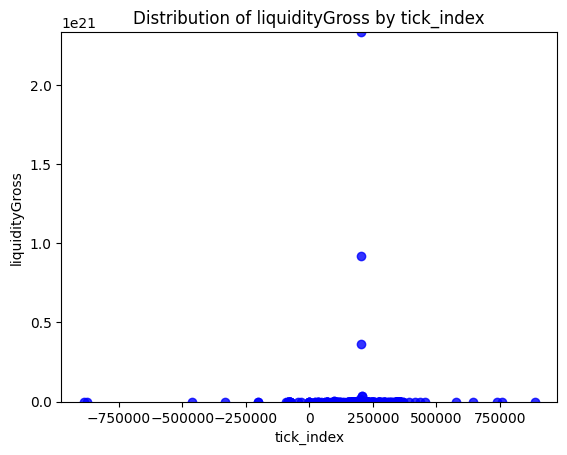

In [170]:
# 设置柱状图的颜色和透明度
color = 'blue'
alpha = 0.8

# 绘制柱状图
plt.scatter(tick_data['tick_index'], tick_data['liquidityGross'], color=color, alpha=alpha)

# 设置横纵坐标的标签和标题
plt.xlabel('tick_index')
plt.ylabel('liquidityGross')
plt.title('Distribution of liquidityGross by tick_index')

# 设置y轴的刻度范围
plt.ylim([0, max(tick_data['liquidityGross'])])

# 显示图形
plt.show()
# todo 分布图画好看点


In [191]:
grouped_df = tick_data.groupby(['tick_index'])['liquidityGross'].sum().reset_index()
grouped_df = grouped_df.sort_values(by="liquidityGross", ascending=False)
# 选择流动性最多的一个tick做为中心
centre_tick = grouped_df["tick_index"].iloc[0]
lower_tick = centre_tick - 3
upper_tick = centre_tick + 3


In [194]:
# 选好了头寸价格范围之后用一样的方法来计算fee
pool_id = "0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640"
query.query_positions(pool_id=pool_id, block_gte=16859000, limit=10, orderBy="owner")
decimal0 = 6
decimal1 = 18
# 初始头寸的美元价值
initial_position = 10000

# 选定时间
begin = datetime(2023, 3, 19)
end = datetime.now()

# 计算价格范围
tickLower = lower_tick
tickUpper = upper_tick
price_low = utils.tickIndex2Price(tickLower)
price_upper = utils.tickIndex2Price(tickUpper)
print("this is the lower price: ", price_low)
print("this is the upper price: ", price_upper)
# 先把tick price转换成sqrtX96的形式
sqrt_p_lower = (price_low ** 0.5) * (2 ** 96)
sqrt_p_upper = (price_upper ** 0.5) * (2 ** 96)
sqrt_p_lower_f = '{:.0f}'.format(sqrt_p_lower)
sqrt_p_upper_f = '{:.0f}'.format(sqrt_p_upper)
# 获取swaps
# swaps = query.query_swaps(begin=int(begin.timestamp()), end=int(end.timestamp()), pool_id=pool_id, sqrtPriceX96_gte=sqrt_p_lower_f, sqrtPriceX96_lte=sqrt_p_upper_f)
swaps = query.query_swaps(begin=int(begin.timestamp()), end=int(end.timestamp()), pool_id=pool_id)

pool_id: 0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640 - type: <class 'str'>
this is the lower price:  631549469.0924171
this is the upper price:  631928493.5189248
this is the cursor: 0x014b234dbb79e8df71f6b1f194f6fbf32b881257d31ce01bc8fa991b2ab7494f#4714867
this is the cursor: 0x02a30ffc11eefc842c4c2df08f20cc13c51e691a2386a7721a2058348cf6de3c#4714932
this is the cursor: 0x03e95850f404a56299347125e6c07b7b151e03dcab36ea8320bd2924dabbb888#4746187
this is the cursor: 0x054d9856779c12155e88847a48b21eea53562927fb143206cf1fe197469a769e#4763797
this is the cursor: 0x06b53351a8c74f2c87ef5ff55395cae8c46b9c1e90d82ba9a0b0acbe278b5e76#4752988
this is the cursor: 0x080df7ae32230cc2d8693ffbac9715bbe2e8a42ce42fca2252a8f34413821d80#4623305
this is the cursor: 0x0965b425c1cad6df05c54420226f5e0aab2f990763ca5ba9a5b1a1f9f1e97d89#4794754
this is the cursor: 0x0ab6ca4426bdcba1a841b95fc99e5cb7428351d977aae87604950836aeb7b03c#4680248
this is the cursor: 0x0c2444b73dbdfa788575d86656238e17eb2691ad5a01f372c659c4a3

In [210]:
swaps1 = swaps
swaps1['tick'] = swaps1['tick'].astype(int)
# 筛选swaps的条件：swap后最终的tick在我们的头寸tick之内
condition = (swaps1['tick'] > tickLower) & (swaps1['tick'] < tickUpper)
# 筛选
print("total swaps: \n", swaps.shape[0])
swaps1 = swaps1[condition]
print("total swaps in range: \n", swaps1.shape[0])
# 这个策略选择出来的tick index有点问题。为什么这么多swap竟然都不在流动性最多的tick之内（可能是特殊情况 todo：处理一下）

total swaps: 
 121000
total swaps in range: 
 0


* * *
### 3 以移动平均价格为中心，选择固定长度的tick

获取价格的时间序列数据，计算移动平均价格，这里的移动窗口选择七天，七天是7*24（168）个小时，



In [212]:
# 计算移动平均价格
# 获取价格
liquidity_data = query.query_liquidity(begin=int(begin.timestamp()), end=int(end.timestamp()), pool_id=pool_id)
liquidity_data

this is the cursor: 1681884000


,periodStartUnix,liquidity,sqrtPrice,token0Price,token1Price,tick,feeGrowthGlobal0X128,feeGrowthGlobal1X128,tvlUSD,volumeToken0,volumeToken1,volumeUSD,feesUSD,txCount,open,high,low,close
0,1679158800,31691854789759819627,1871666948661873416199899917784088,1791.851542392230339967547914533666,0.0005580819483878331967604985081167192,201410,2314975469199928457298700227744982,1111162292302232016625192018264273618935405,362517939.1226720089381000671278629,0,0,0,0,372,1798.390894813620679474180985197866,1803.236399827628569085607995221095,1769.953587075568576406795835267567,1791.851542392230339967547914533666
1,1679162400,32915185914729732691,1867893400320714844515651086096830,1799.098710137099104209582500255936,0.0005558338707962253356429190522474716,201369,2315038215475779131181192686558395,1111189202831556094328153678234461295869361,363811618.6075028876192885997227013,0,0,0,0,366,1790.640320160079804025064362917098,1799.108571408040728063168297875355,1786.686354081499257894742581324593,1799.098710137099104209582500255936
2,1679166000,34369179026466248085,1869482743679436927327266292647007,1796.040997899866322473028892703993,0.0005567801632419932350116030494839081,201386,2315126854003039415933596971303595,1111241826769754789231620166343530092470985,363967492.8611761592527996744286012,0,0,0,0,333,1799.099225334904656531075427168004,1809.622901299084675474781496124223,1794.120699231514675114167039962852,1796.040997899866322473028892703993
3,1679169600,34183163223601833767,1868781276195693273308669229878293,1797.389578204559120182790388692096,0.000556362411424970994583196746389777,201379,2315168855482994101747218874079807,1111263525863761589158339866419647898430929,363205815.9317762712257394030005428,0,0,0,0,317,1796.054690522833853305120372567828,1805.57781837591635090288239389413,1792.725482994450340228488201862034,1797.389578204559120182790388692096
4,1679173200,34246952167731560476,1875752556320845172108591732547304,1784.054320332921814271944303424757,0.0005605210495011106585938907612211571,201453,2315193497548537858877306471738285,1111292420021385719852093400706179840724576,360909125.4200933323216227809336806,0,0,0,0,309,1797.199358810234823401563218695319,1797.220201287329445413990798860576,1783.038903387140753714413070004309,1784.054320332921814271944303424757
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
753,1681869600,38696268321506641307,1731730613788735128367474453908689,2093.141066310761960519078663318802,0.0004777508865002284551572890373283793,199855,2348188118115489021408056256593135,1128789383510024757402860646673166921096463,493026412.4847887750671122394161627,0,0,0,0,301,2096.657705178813031825052184474242,2096.689485890473822705737024962295,2090.728863559289778025260790458539,2093.141066310761960519078663318802
754,1681873200,43337687431704050072,1732368223776013442605750669981933,2091.600560055098047110199128567011,0.0004781027597227538854843677666452811,199863,2348204525237566200652391235060771,1128798564745978517296852360439222311459537,493067943.1974335344079980960030117,0,0,0,0,240,2093.122726888745338756281977750403,2097.070099923497941495023276854657,2089.386812749012333668101756365353,2091.600560055098047110199128567011
755,1681876800,37544756938238646957,1734647823103291905730737950509721,2086.106789839779024190929071649195,0.0004793618451703538257496543904852171,199889,2348216384994805977752066454526036,1128809149101789364259390642109690340551935,492424539.3435394293043370814610672,0,0,0,0,227,2091.590411798472402827075358459162,2091.590411798472402827075358459162,2084.825452902400734719513523174232,2086.106789839779024190929071649195
756,1681880400,37622934048870921166,1732971326560261395272185842433188,2090.14498996090869691850119760142,0.0004784357089116112826709096071704188,199870,2348238623381054972605813313843889,1128816190539916232580945483983413769193617,490667218.7269553343321736398415036,0,0,0,0,213,2086.089289080205725650765783515639,2092.4627921006049528379085621715

In [234]:
swaps.sort_values("tick")

,id,timestamp,sender,recipient,origin,amount0,amount1,amountUSD,sqrtPriceX96,tick,logIndex
55542,0x4baf4c4e4c1f22040e8b79d0874e6374436fe98bbb03...,1681671623,0xa69babef1ca67a37ffaf7a485dfff3382056e78c,0xa69babef1ca67a37ffaf7a485dfff3382056e78c,0x26bce6ecb5b10138e4bf14ac0ffcc8727fef3b2e,1131605.417578,-529.070156287077891789,1129201.918379455496878075176781428,1712462355565571222308393082444477,199632,5
24512,0x2171f08b736c41f665856290565e27ffbbc3b806dcfc...,1681671623,0xa69babef1ca67a37ffaf7a485dfff3382056e78c,0xa69babef1ca67a37ffaf7a485dfff3382056e78c,0x75bcdbc99d9ce8ea5c8b0298cf2db409c8a9790a,791829.161574,-370.070544517386743766,790993.615635681255766981041378223,1712462355565571222308393082444477,199632,505
83094,0x715d26b084a214ca839e4796591ac07dfe08847e5d64...,1681671623,0x6a5ef39f58c80e42642b9210bf74f20666a2e6b6,0x9a772018fbd77fcd2d25657e5c547baff3fd7d16,0xa023b8552ea409833f3007c4477c293c8617ef13,-277221.669269,129.617298185349642249,276638.4335816076836190143487777412,1712997475281853773453457885554409,199638,10
155833,0xd4b18c1cb239a80d39719e592df709e5efc35ff695bc...,1681671623,0x40e9a6c74c270b3e66cf363d16f8e522abb620c1,0x6e1fbeeaba87bae1100d95f8340dc27ad7c8427b,0xaf2d7fc370d6ae13b9d9780f46baa508b7710a96,-7903.954404,3.697880599057881224,7889.79713365123702253756715303431,1713275262685616933432778746755695,199641,31
142652,0xc2a3d485f70ec18d70cbb8462623ff45834c85131c58...,1681671623,0x6a5ef39f58c80e42642b9210bf74f20666a2e6b6,0x4622df6fb2d9bee0dcdacf545acdb6a2b2f4f863,0x15cc546a2c1153b9a89e6e2d524c6ca95f661162,-13478.278748,6.305991010333468825,13454.29861836044065703806862467033,1713301262933302582320123365856084,199641,36
...,...,...,...,...,...,...,...,...,...,...,...
46286,0x3f027943a39f80db4e1bf05758c5dfefb522e165a7f4...,1679929799,0xa80db00007020e013fa10d0560700c0018003b8b,0xa80db00007020e013fa10d0560700c0018003b8b,0x00000006e42915a2b6907f8b3faf311b68862f60,1814.703563,-1.073543209718799487,1816.490516677284318148550846088927,1927499909357143686271751294391444,201998,131
91459,0x7ce81c21a23bf82966913b17f660a8a143923174d013...,1679929883,0xef1c6e67703c7bd7107eed8303fbe6ec2554bf6b,0x4cb6b232144996587170e02225cf038910c99f63,0x4cb6b232144996587170e02225cf038910c99f63,-7496.992255,4.44,7500.811907988012148361719253524845,1927622482994140092796312541470118,201999,332
38005,0x339fa2052432b5c4f92f85ea1a953e084eda9605bc9d...,1679929883,0xe592427a0aece92de3edee1f18e0157c05861564,0x22f9dcf4647084d6c31b2765f6910cd85c178c18,0xb9e025a1363373e48da72f7e4f6eb7cddf2f6501,-422118.239728,249.793662879577465158,422163.7827218696180886867645531957,1927595442175448117341177130404032,201999,81
109782,0x95cdf01235120fd70b874d36026e3980b2ba8c1bc6bc...,1679929931,0xef1c6e67703c7bd7107eed8303fbe6ec2554bf6b,0xef1c6e67703c7bd7107eed8303fbe6ec2554bf6b,0x4a8b9aa0aafb23261ca70dbd4a4a7bfb3ae02410,-505472.514136,299.186681769207997785,505583.758715397347640149947241435,1927763941607508929667006468752016,202000,8


In [241]:
upper_tick

200033.84523809524

In [254]:
tickUpper

200033.84523809524

In [255]:
ma_data = utils.moving_average(liquidity_data, 168)
# 选最近的一个价格作为tick的中心, 以3为固定长度
centre_tick = ma_data["tick"].iloc[-1]
upper_tick = centre_tick + 3
lower_tick = centre_tick - 3

# 计算价格范围
tickLower = lower_tick
tickUpper = upper_tick
price_low = utils.tickIndex2Price(tickLower)
price_upper = utils.tickIndex2Price(tickUpper)
print("this is the lower price: ", price_low)
print("this is the upper price: ", price_upper)
# 先把tick price转换成sqrtX96的形式
sqrt_p_lower = (price_low ** 0.5) * (2 ** 96)
sqrt_p_upper = (price_upper ** 0.5) * (2 ** 96)
sqrt_p_lower_f = '{:.0f}'.format(sqrt_p_lower)
sqrt_p_upper_f = '{:.0f}'.format(sqrt_p_upper)
# 获取swaps
# swaps = query.query_swaps(begin=int(begin.timestamp()), end=int(end.timestamp()), pool_id=pool_id, sqrtPriceX96_gte=sqrt_p_lower_f, sqrtPriceX96_lte=sqrt_p_upper_f)
swaps = query.query_swaps(begin=int(begin.timestamp()), end=int(end.timestamp()), pool_id=pool_id)
swaps1 = swaps
swaps1["tick"] = swaps1["tick"].astype(float)
condition = (swaps1['tick'] > tickLower) & (swaps1['tick'] < tickUpper)
# 筛选
print("total swaps: \n", swaps.shape[0])
swaps1 = swaps1[condition]
print("total swaps in range: \n", swaps1.shape[0])

this is the lower price:  486031721.9574581
this is the upper price:  486323413.9051122
total swaps: 
 187427
total swaps in range: 
 20


In [268]:
liquidity_data

,timestamp,ratio
0,1679158800,1.151905e-20
1,1679162400,1.109093e-20
2,1679166000,1.062173e-20
3,1679169600,1.067953e-20
4,1679173200,1.065963e-20
...,...,...
753,1681869600,9.433985e-21
754,1681873200,8.423615e-21
755,1681876800,9.723328e-21
756,1681880400,9.703124e-21


In [275]:
# 竟然只有20个在range内，可能需要调整一下固定长度
# 计算fee
# 先计算liquidity的大小
# 初始头寸的美元价值为10000usdc
liquidity_data = query.query_liquidity(begin=int(begin.timestamp()), end=int(end.timestamp()), pool_id=pool_id)
liquidity_data["sqrtPrice"] = liquidity_data["sqrtPrice"].astype(float)
liquidity_data["liquidity"] = liquidity_data["liquidity"].astype(float)
liquidity_data["real_price"] = liquidity_data["sqrtPrice"].astype(float).apply(lambda x: utils.sqrtPrice2Price(x))
liquidity_data["currentTickIndex"] = liquidity_data["real_price"].astype(float).apply(lambda x: utils.price2TickIndex(x))
upperPrice = utils.tickIndex2Price(upper_tick)
lowerPrice = utils.tickIndex2Price(lower_tick)

initial_position = 10000
position_token0_amount = 5000.0
real_price_token1 = 1 / (utils.price2RealPrice(liquidity_data["real_price"].iloc[-1], 6, 18))
position_token1_amount = 5000  / real_price_token1
liquidity = utils.calculateLiquidity(token0_amount=position_token0_amount, token1_amount=position_token1_amount, price_low=lowerPrice, price_upper=upperPrice)
liquidity_data["ratio"] = liquidity / liquidity_data["liquidity"]

liquidity_data = liquidity_data[["periodStartUnix", "ratio"]]
liquidity_data = liquidity_data.rename(columns={"periodStartUnix": "timestamp", "ratio": "ratio"})
# 先排序
swaps1["timestamp"] = swaps1["timestamp"].astype(int)
swaps1 = swaps1.sort_values(by="timestamp")
liquidity_data = liquidity_data.sort_values(by="timestamp")
# 找liquidity data只时间最接近的来合并
merged_data = pd.merge_asof(
    swaps1,
    liquidity_data[["timestamp", "ratio"]],
    on="timestamp",
    direction="nearest"
)

# 计算手续费
liquidity_data["ratio"] = liquidity_data["ratio"].astype(float)
merged_data['amount0'] = merged_data['amount0'].astype(float).apply(lambda x: max(0, x))
merged_data['amount1'] = merged_data['amount1'].astype(float).apply(lambda x: max(0, x))

merged_data["fee0"] = merged_data["amount0"] * merged_data['ratio'] * 0.0005
fee0_sum = merged_data["fee0"].sum()

merged_data["fee1"] = merged_data["amount1"] * merged_data['ratio'] * 0.0005
fee1_sum = merged_data["fee1"].sum()

print(fee0_sum)
print(fee1_sum)

this is the cursor: 1681884000
8.087660403398314e-18
3.365483625044773e-21


***

### 3 布林带


In [279]:
type(liquidity_data["timestamp"])

pandas.core.series.Series

In [293]:
# 计算布林带
# 默认配置：window_size=20, num_std=2(大约95%的数据会落在区间内)
liquidity_data = query.query_liquidity(begin=int(begin.timestamp()), end=int(end.timestamp()), pool_id=pool_id)

this is the cursor: 1681884000


In [295]:
tick_index_data.index

RangeIndex(start=0, stop=758, step=1)

In [305]:
tick_index_data = liquidity_data["tick"]
# 为了方便 我直接拿tick来算了
bollinger_bands = utils.calculate_bollinger_bands(tick_index_data)
bollinger_bands

,price,middle_band,upper_band,lower_band
0,201410,NaN,NaN,NaN
1,201369,NaN,NaN,NaN
2,201386,NaN,NaN,NaN
3,201379,NaN,NaN,NaN
4,201453,NaN,NaN,NaN
...,...,...,...,...
753,199855,199831.95,199935.545316,199728.354684
754,199863,199834.50,199938.537443,199730.462557
755,199889,199837.30,199944.143910,199730.456090
756,199870,199841.30,199946.667727,199735.932273


In [310]:
# 选取tick上限和下限
tickLower = bollinger_bands.iloc[-1][0]
tickUpper = bollinger_bands.iloc[0][0]

# 计算fee
pool_id = "0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640"
query.query_positions(pool_id=pool_id, block_gte=16859000, limit=10, orderBy="owner")
decimal0 = 6
decimal1 = 18
# 初始头寸的美元价值
initial_position = 10000

# 选定时间
begin = datetime(2023, 3, 19)
end = datetime.now()

# 计算价格范围
tickLower = lower_tick
tickUpper = upper_tick
price_low = utils.tickIndex2Price(tickLower)
price_upper = utils.tickIndex2Price(tickUpper)
print("this is the lower price: ", price_low)
print("this is the upper price: ", price_upper)
# 先把tick price转换成sqrtX96的形式
sqrt_p_lower = (price_low ** 0.5) * (2 ** 96)
sqrt_p_upper = (price_upper ** 0.5) * (2 ** 96)
sqrt_p_lower_f = '{:.0f}'.format(sqrt_p_lower)
sqrt_p_upper_f = '{:.0f}'.format(sqrt_p_upper)
# 获取swaps
# swaps = query.query_swaps(begin=int(begin.timestamp()), end=int(end.timestamp()), pool_id=pool_id, sqrtPriceX96_gte=sqrt_p_lower_f, sqrtPriceX96_lte=sqrt_p_upper_f)
swaps = query.query_swaps(begin=int(begin.timestamp()), end=int(end.timestamp()), pool_id=pool_id)

swaps1 = swaps
swaps1['tick'] = swaps1['tick'].astype(int)
# 筛选swaps的条件：swap后最终的tick在我们的头寸tick之内
condition = (swaps1['tick'] > tickLower) & (swaps1['tick'] < tickUpper)
# 筛选
print("total swaps: \n", swaps.shape[0])
swaps1 = swaps1[condition]
print("total swaps in range: \n", swaps1.shape[0])


pool_id: 0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640 - type: <class 'str'>
this is the lower price:  486031721.9574581
this is the upper price:  486323413.9051122
this is the cursor: 0x0148aa9feef2c671e2c3e976ff8d8546a8e78239c613535e0b160bab5c4e6233#4761784
this is the cursor: 0x029d88fb6f7aa6987a6eaf7d26e7682def3ac11f67ebc72b59d5c1ccb257bf8e#4647675
this is the cursor: 0x03e116287dede88d8aa05b9c7132163fa26861e4084a373c6e11bd17db13760a#4698916
this is the cursor: 0x0544a00fa28567e02b79e8675b6abf7b246dff134e118ca270f5011f6f36476c#4746278
this is the cursor: 0x06a68f25f4aa4b8a89de4f1eff1b30dbe0f830cf094d8c7b8f61d84a337f03c4#4648059
this is the cursor: 0x07fec8969c1f18618fe87cd7eff52fd3395c45076aa72ac2fc60c7d0f008f730#4684409
this is the cursor: 0x0952e64a5bdbf9b07d941aea864daca590ed500e7be5bfb8abbcdbdf764a61f0#4687150
this is the cursor: 0x0aa546af09a45da9dbba3349982726588ab7872ecf93ec8d357e65cb348714dc#4812036
this is the cursor: 0x0c04cdd2b6ad783d529e0e394349f9ab42f2d4f038afb3b508f597b7

In [311]:
# 竟然只有20个在range内，可能需要调整一下固定长度
# 计算fee
# 先计算liquidity的大小
# 初始头寸的美元价值为10000usdc
liquidity_data = query.query_liquidity(begin=int(begin.timestamp()), end=int(end.timestamp()), pool_id=pool_id)
liquidity_data["sqrtPrice"] = liquidity_data["sqrtPrice"].astype(float)
liquidity_data["liquidity"] = liquidity_data["liquidity"].astype(float)
liquidity_data["real_price"] = liquidity_data["sqrtPrice"].astype(float).apply(lambda x: utils.sqrtPrice2Price(x))
liquidity_data["currentTickIndex"] = liquidity_data["real_price"].astype(float).apply(lambda x: utils.price2TickIndex(x))
upperPrice = utils.tickIndex2Price(upper_tick)
lowerPrice = utils.tickIndex2Price(lower_tick)

initial_position = 10000
position_token0_amount = 5000.0
real_price_token1 = 1 / (utils.price2RealPrice(liquidity_data["real_price"].iloc[-1], 6, 18))
position_token1_amount = 5000  / real_price_token1
liquidity = utils.calculateLiquidity(token0_amount=position_token0_amount, token1_amount=position_token1_amount, price_low=lowerPrice, price_upper=upperPrice)
liquidity_data["ratio"] = liquidity / liquidity_data["liquidity"]

liquidity_data = liquidity_data[["periodStartUnix", "ratio"]]
liquidity_data = liquidity_data.rename(columns={"periodStartUnix": "timestamp", "ratio": "ratio"})
# 先排序
swaps1["timestamp"] = swaps1["timestamp"].astype(int)
swaps1 = swaps1.sort_values(by="timestamp")
liquidity_data = liquidity_data.sort_values(by="timestamp")
# 找liquidity data只时间最接近的来合并
merged_data = pd.merge_asof(
    swaps1,
    liquidity_data[["timestamp", "ratio"]],
    on="timestamp",
    direction="nearest"
)

# 计算手续费
liquidity_data["ratio"] = liquidity_data["ratio"].astype(float)
merged_data['amount0'] = merged_data['amount0'].astype(float).apply(lambda x: max(0, x))
merged_data['amount1'] = merged_data['amount1'].astype(float).apply(lambda x: max(0, x))

merged_data["fee0"] = merged_data["amount0"] * merged_data['ratio'] * 0.0005
fee0_sum = merged_data["fee0"].sum()

merged_data["fee1"] = merged_data["amount1"] * merged_data['ratio'] * 0.0005
fee1_sum = merged_data["fee1"].sum()

print(fee0_sum)
print(fee1_sum)

this is the cursor: 1681902000
8.475207306184355e-18
1.103790798206467e-20
